# Fun with Variational Autoencoders

This is a starter kernel to use **Labelled Faces in the Wild (LFW) Dataset** in order to maintain knowledge about main Autoencoder principles. PyTorch will be used for modelling.


## Fork it and give it an upvote.




![architecture](https://miro.medium.com/max/3636/1*LSYNW5m3TN7xRX61BZhoZA.png)

Useful links:


* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Introducing Variational Autoencoders (in Prose and Code)](https://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html)
* [How Autoencoders work - Understanding the math and implementation (Notebook)](https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases)
* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)



## A bit of theory

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

source: https://blog.keras.io/building-autoencoders-in-keras.html


In [3]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import requests

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

ModuleNotFoundError: No module named 'torch'

In [11]:
datasets_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/variational-autoencoder-and-faces-generation/lfw-deepfunneled.zip"
attributes_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/autoencoder/variational-autoencoder-and-faces-generation/lfw_attributes.txt"

notebook_path = os.getcwd()

tmp_folder_path = os.path.join(notebook_path, "tmp")

if not os.path.exists(tmp_folder_path):
    os.makedirs(tmp_folder_path)

tmp_zip_path = os.path.join(tmp_folder_path,"zip-store")

if not os.path.exists(tmp_zip_path):
    os.makedirs(tmp_zip_path)
    
datasets_response = requests.get(datasets_url)
attributes_response = requests.get(attributes_url)

datasets_name = os.path.basename(datasets_url)
attributes_name = os.path.basename(attributes_url)

datasets_save_path = os.path.join(tmp_zip_path, datasets_name)
attributes_save_path = os.path.join(tmp_zip_path, attributes_name)

with open(datasets_save_path, "wb") as file:
    file.write(datasets_response.content)

with open(attributes_save_path, "wb") as file:
    file.write(attributes_response.content)

KeyboardInterrupt: 

In [13]:
datasets_name = "lfw-deepfunneled.zip"

In [16]:
import zipfile

zip_file_path = f"./tmp/zip-store/{datasets_name}"
extract_path = "./tmp/"

zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

In [9]:
DATASET_PATH ="./tmp/lfw-deepfunneled/"
ATTRIBUTES_PATH = "./tmp/lfw_attributes.txt"

## Explore the data

Image data is collected from DATASET_PATH and a dataset is created in which the person information for each image is extracted and used for subsequent data analysis or processing. Finally, the filter() function is used to limit the size of the dataset by retaining only information about people who appear less than 25 times.

In [55]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)

dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

person                                               path
0   Ellen_Saracini  ./lfw-deepfunneled/Ellen_Saracini/Ellen_Saraci...
1       Lydia_Shum  ./lfw-deepfunneled/Lydia_Shum/Lydia_Shum_0001.jpg
2     Yale_Kamisar  ./lfw-deepfunneled/Yale_Kamisar/Yale_Kamisar_0...
3    Pinar_del_Rio  ./lfw-deepfunneled/Pinar_del_Rio/Pinar_del_Rio...
4  Larry_Tanenbaum  ./lfw-deepfunneled/Larry_Tanenbaum/Larry_Tanen...
5   Kristen_Rivera  ./lfw-deepfunneled/Kristen_Rivera/Kristen_Rive...
6   Matt_Siebrandt  ./lfw-deepfunneled/Matt_Siebrandt/Matt_Siebran...
7      Ringo_Starr  ./lfw-deepfunneled/Ringo_Starr/Ringo_Starr_000...
8   Lee_Ann_Knight  ./lfw-deepfunneled/Lee_Ann_Knight/Lee_Ann_Knig...
9      Tanya_Holyk  ./lfw-deepfunneled/Tanya_Holyk/Tanya_Holyk_000...

Let's group the dataset and look at the amount of photo data for the first 200 people.

<Axes: xlabel='person'>

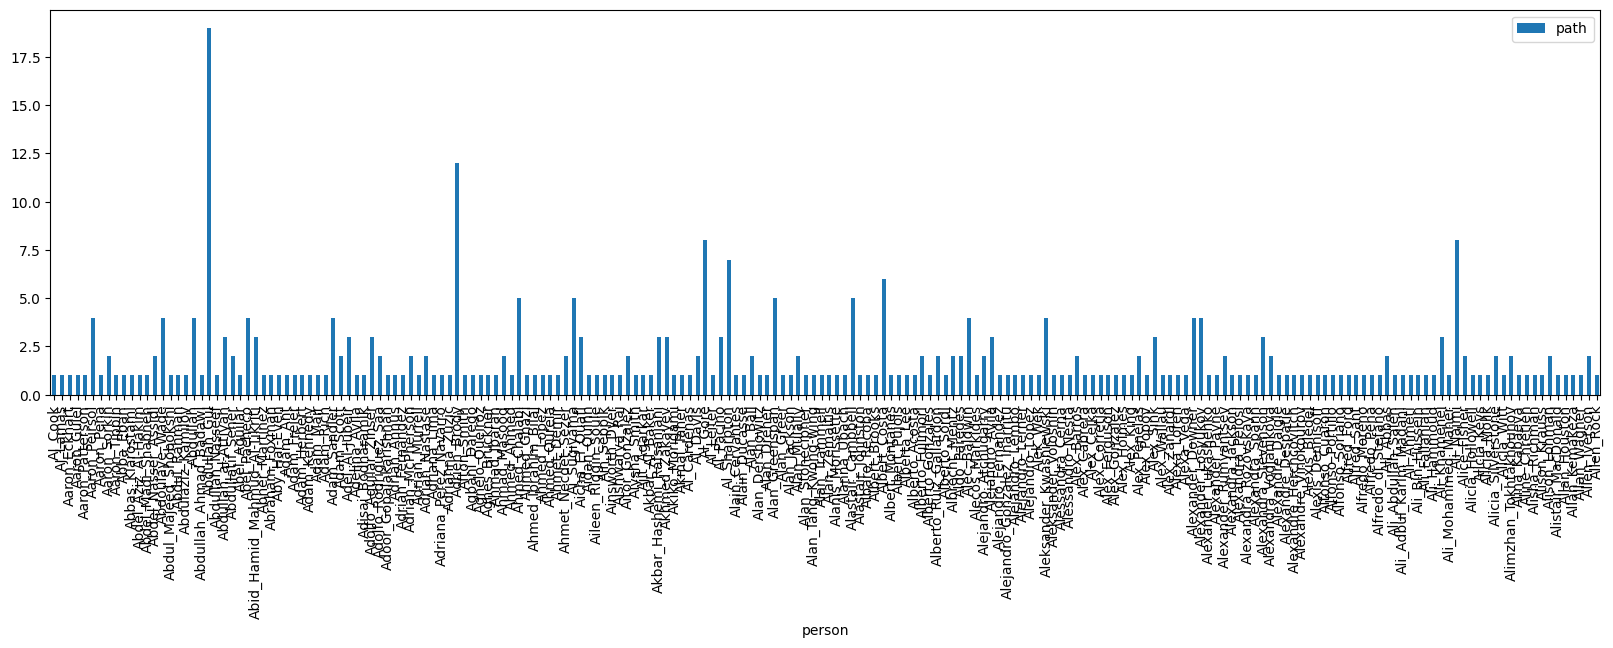

In [56]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

And take a random look at the photos of people in the dataset.

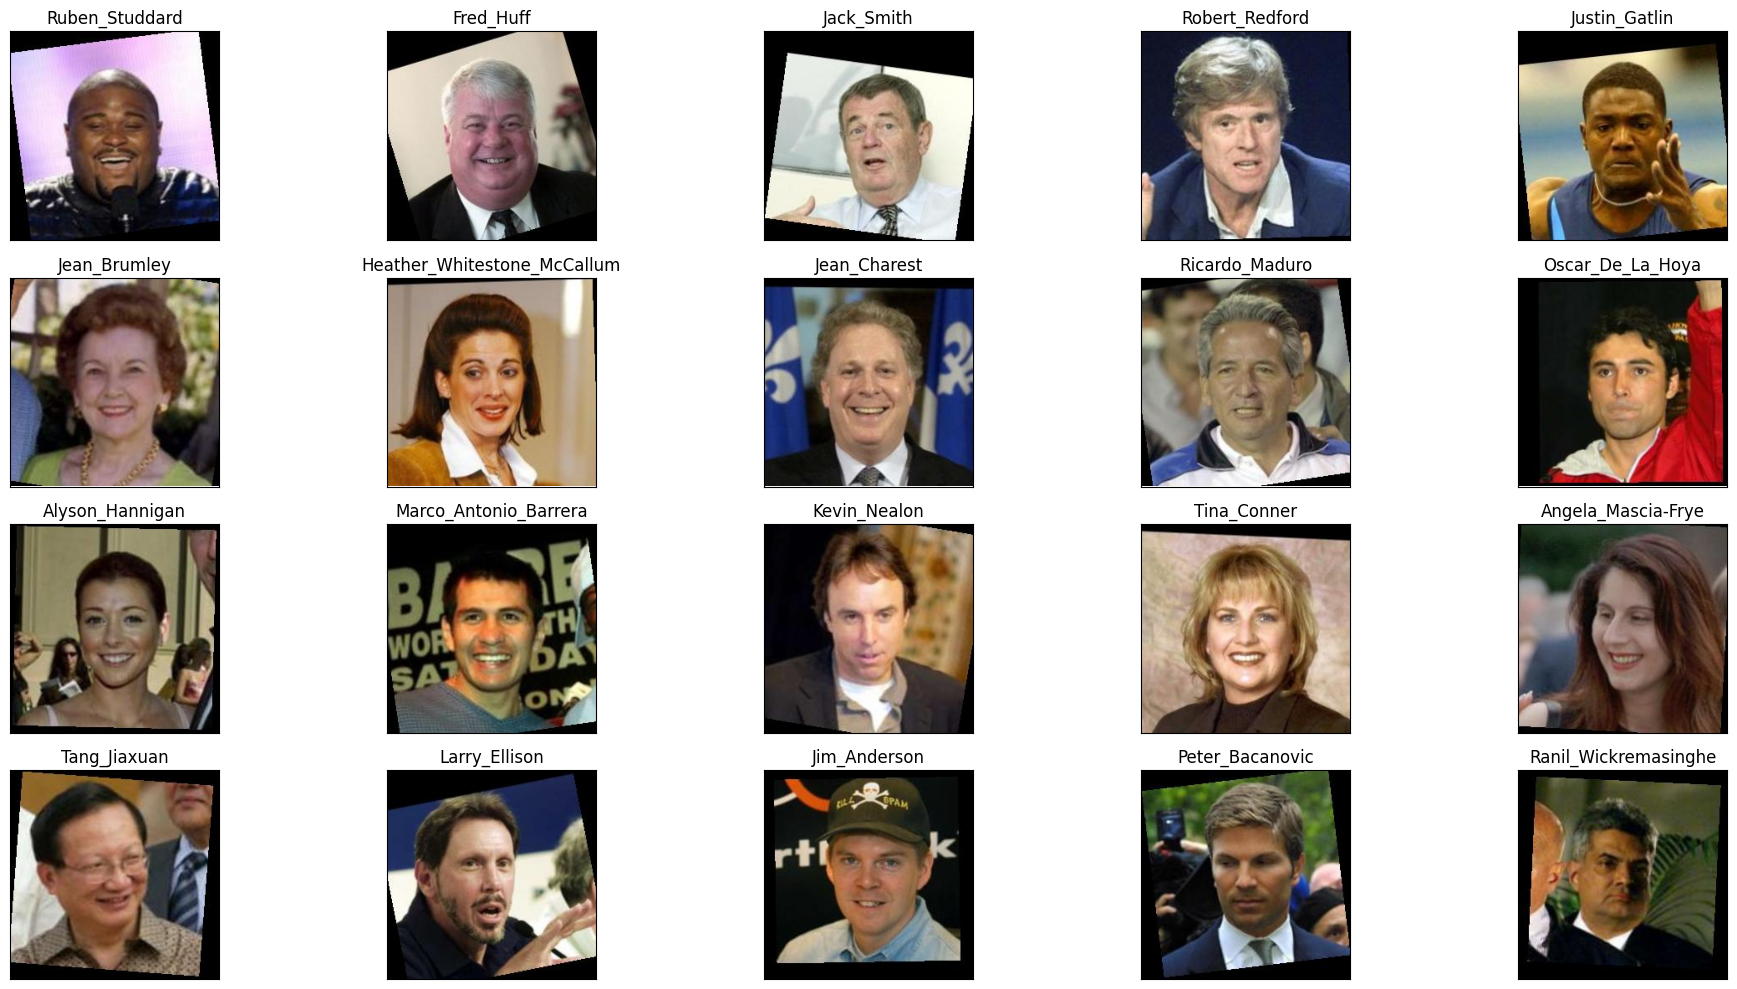

In [57]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Prepare the dataset

> - Reads the attribute data from the txt file at the specified path and stores it in a DataFrame object called df_attrs. The txt file is tab delimited, skipping the first line.
> - Empty list photo_ids for storing photo IDs, paths and person information. Use os.walk() to iterate through the files and folders under the specified path. For each file, if the filename ends in .jpg, extract its path, person information and photo number and add them to the photo_ids list.
> - Then convert the photo_ids list into a DataFrame object and merge it with df_attrs, based on common columns ("person" and "imagenum"). The result is stored in a DataFrame object called df.
> - Use the assertion statement to check that the length of the merged DataFrame object is the same as the length of the original attribute data to ensure that no data is missing.
> - Based on the paths of the photos in the merged DataFrame, the image data for each photo is read using the imageio.imread() function. Each image is then subjected to a series of processes, including cropping, resizing, etc., and the processed image data is stored in a NumPy array called all_photos.
> - Remove the photo path, person information and photo number from the merged DataFrame and store the result in a DataFrame object called all_attrs.

In [58]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [59]:
data, attrs = fetch_dataset()

Get the height and width of the image from data and define the number of channels.

In [60]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

Normalize the data and divide the training and test sets.

In [61]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [62]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

## Building simple autoencoder

In [63]:
dim_z=100

In [64]:
X_train.shape

torch.Size([10514, 45, 45, 3])

In [65]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            #nn.Linear(500,1000),
            #nn.ReLU(),
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        encoded = self.encode(x) 
        decoded = self.decode(encoded)     

        
        return encoded, decoded

This model will not be used in the following codes, but you can use it to instead of Autoencoder() to see the difference.

In [66]:
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5, stride=2)
        )
        
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        x = x.permute(0,3,1,2)
        encoded = self.encoder(x)  
        decoded = self.decode(encoded)     

        
        return encoded, decoded

In [67]:
model_auto = Autoencoder().to(DEVICE)

## Train autoencoder

> - get_batch: It uses the Generator method to generate batches of a specified size by iterating over them. The amount of data generated is batch_size each time, until the entire data set is traversed.
> - plot_gallery: This function is used to visualise an image.
> - fit_epoch: This function is used to perform the training process of the model. The function traverses the training data set, feeds the data into the model for forward propagation, calculates losses, back propagation and parameter updates. Finally the training loss is returned.
> - eval_epoch: This function is used to perform the validation process of the model. The function traverses the validation data set, feeds the data into the model for forward propagation and calculates the loss. Finally the validation loss is returned.


In [68]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        #print('decoder shape: ', decoder.shape)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
        pic_input = pic_input.to(DEVICE)        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")        
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss



In [69]:
def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size,is_cnn)
            val_loss = eval_epoch(model,val_x,criterion, is_cnn)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   2%|▏         | 1/50 [00:02<02:25,  2.98s/it]

loss:  0.02875132167090736

Epoch 001 train_loss: 0.0288 val_loss: 0.0163


epoch:   4%|▍         | 2/50 [00:05<02:19,  2.91s/it]

loss:  0.01261101564045571

Epoch 002 train_loss: 0.0126 val_loss: 0.0114


epoch:   6%|▌         | 3/50 [00:08<02:14,  2.85s/it]

loss:  0.01078065369467398

Epoch 003 train_loss: 0.0108 val_loss: 0.0103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:   8%|▊         | 4/50 [00:11<02:11,  2.85s/it]

loss:  0.009774858615647619

Epoch 004 train_loss: 0.0098 val_loss: 0.0097


epoch:  10%|█         | 5/50 [00:14<02:12,  2.94s/it]

loss:  0.008984292351029741

Epoch 005 train_loss: 0.0090 val_loss: 0.0087


epoch:  12%|█▏        | 6/50 [00:17<02:08,  2.93s/it]

loss:  0.008495535750320474

Epoch 006 train_loss: 0.0085 val_loss: 0.0083


epoch:  14%|█▍        | 7/50 [00:20<02:04,  2.90s/it]

loss:  0.008080331142991781

Epoch 007 train_loss: 0.0081 val_loss: 0.0079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  16%|█▌        | 8/50 [00:23<02:02,  2.92s/it]

loss:  0.007711527520723021

Epoch 008 train_loss: 0.0077 val_loss: 0.0079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  18%|█▊        | 9/50 [00:26<02:00,  2.94s/it]

loss:  0.007531445572198441

Epoch 009 train_loss: 0.0075 val_loss: 0.0075


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  20%|██        | 10/50 [00:29<01:56,  2.91s/it]

loss:  0.007380892082748359

Epoch 010 train_loss: 0.0074 val_loss: 0.0074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  22%|██▏       | 11/50 [00:32<01:56,  2.99s/it]

loss:  0.0070740288493395505

Epoch 011 train_loss: 0.0071 val_loss: 0.0071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  24%|██▍       | 12/50 [00:35<01:57,  3.08s/it]

loss:  0.006947317923953665

Epoch 012 train_loss: 0.0069 val_loss: 0.0077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  26%|██▌       | 13/50 [00:39<01:59,  3.23s/it]

loss:  0.0066056935619247525

Epoch 013 train_loss: 0.0066 val_loss: 0.0067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  28%|██▊       | 14/50 [00:43<02:05,  3.49s/it]

loss:  0.0064327935474721544

Epoch 014 train_loss: 0.0064 val_loss: 0.0072


epoch:  30%|███       | 15/50 [00:47<02:09,  3.70s/it]

loss:  0.0063303188543603044

Epoch 015 train_loss: 0.0063 val_loss: 0.0072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  32%|███▏      | 16/50 [00:51<02:05,  3.69s/it]

loss:  0.006140560925163474

Epoch 016 train_loss: 0.0061 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  34%|███▍      | 17/50 [00:54<02:03,  3.75s/it]

loss:  0.00593797971473414

Epoch 017 train_loss: 0.0059 val_loss: 0.0063


epoch:  36%|███▌      | 18/50 [00:58<02:00,  3.76s/it]

loss:  0.0059195215356215025

Epoch 018 train_loss: 0.0059 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  38%|███▊      | 19/50 [01:01<01:50,  3.58s/it]

loss:  0.005835473057345358

Epoch 019 train_loss: 0.0058 val_loss: 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  40%|████      | 20/50 [01:05<01:44,  3.48s/it]

loss:  0.005775634106549786

Epoch 020 train_loss: 0.0058 val_loss: 0.0060


/tmp/ipykernel_10479/1482019581.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  42%|████▏     | 21/50 [01:08<01:43,  3.56s/it]

loss:  0.005573070473793241

Epoch 021 train_loss: 0.0056 val_loss: 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  44%|████▍     | 22/50 [01:12<01:40,  3.58s/it]

loss:  0.0055614186898873055

Epoch 022 train_loss: 0.0056 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  46%|████▌     | 23/50 [01:16<01:36,  3.57s/it]

loss:  0.0055600714421408905

Epoch 023 train_loss: 0.0056 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  48%|████▊     | 24/50 [01:19<01:34,  3.62s/it]

loss:  0.00539352769965392

Epoch 024 train_loss: 0.0054 val_loss: 0.0060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  50%|█████     | 25/50 [01:23<01:30,  3.62s/it]

loss:  0.005241526854758636

Epoch 025 train_loss: 0.0052 val_loss: 0.0059


epoch:  52%|█████▏    | 26/50 [01:26<01:24,  3.53s/it]

loss:  0.0052163708214172395

Epoch 026 train_loss: 0.0052 val_loss: 0.0060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  54%|█████▍    | 27/50 [01:29<01:18,  3.41s/it]

loss:  0.005276495684168571

Epoch 027 train_loss: 0.0053 val_loss: 0.0059


epoch:  56%|█████▌    | 28/50 [01:33<01:15,  3.42s/it]

loss:  0.005188193595492516

Epoch 028 train_loss: 0.0052 val_loss: 0.0059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  58%|█████▊    | 29/50 [01:37<01:14,  3.55s/it]

loss:  0.0050920886693556705

Epoch 029 train_loss: 0.0051 val_loss: 0.0060


epoch:  60%|██████    | 30/50 [01:40<01:11,  3.55s/it]

loss:  0.0049741322897741

Epoch 030 train_loss: 0.0050 val_loss: 0.0067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  62%|██████▏   | 31/50 [01:44<01:09,  3.67s/it]

loss:  0.00503561065520929

Epoch 031 train_loss: 0.0050 val_loss: 0.0065


epoch:  64%|██████▍   | 32/50 [01:47<01:03,  3.53s/it]

loss:  0.0051317932533742625

Epoch 032 train_loss: 0.0051 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  66%|██████▌   | 33/50 [01:50<00:56,  3.34s/it]

loss:  0.005004038279241885

Epoch 033 train_loss: 0.0050 val_loss: 0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  68%|██████▊   | 34/50 [01:54<00:53,  3.34s/it]

loss:  0.004894608484422733

Epoch 034 train_loss: 0.0049 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  70%|███████   | 35/50 [01:57<00:48,  3.22s/it]

loss:  0.0048211010626311905

Epoch 035 train_loss: 0.0048 val_loss: 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  72%|███████▏  | 36/50 [02:00<00:45,  3.29s/it]

loss:  0.00474728227633574

Epoch 036 train_loss: 0.0047 val_loss: 0.0062


epoch:  74%|███████▍  | 37/50 [02:04<00:44,  3.39s/it]

loss:  0.004876280503612545

Epoch 037 train_loss: 0.0049 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  76%|███████▌  | 38/50 [02:07<00:40,  3.34s/it]

loss:  0.004926490656597852

Epoch 038 train_loss: 0.0049 val_loss: 0.0061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  78%|███████▊  | 39/50 [02:10<00:36,  3.33s/it]

loss:  0.004772245157192928

Epoch 039 train_loss: 0.0048 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  80%|████████  | 40/50 [02:13<00:33,  3.31s/it]

loss:  0.004690238864571905

Epoch 040 train_loss: 0.0047 val_loss: 0.0062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  82%|████████▏ | 41/50 [02:16<00:28,  3.22s/it]

loss:  0.004702869016749422

Epoch 041 train_loss: 0.0047 val_loss: 0.0065


epoch:  84%|████████▍ | 42/50 [02:20<00:26,  3.30s/it]

loss:  0.004645392128227596

Epoch 042 train_loss: 0.0046 val_loss: 0.0066


epoch:  86%|████████▌ | 43/50 [02:24<00:24,  3.50s/it]

loss:  0.0046567028805678005

Epoch 043 train_loss: 0.0047 val_loss: 0.0061


epoch:  88%|████████▊ | 44/50 [02:27<00:21,  3.51s/it]

loss:  0.0046549430296827015

Epoch 044 train_loss: 0.0047 val_loss: 0.0063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  90%|█████████ | 45/50 [02:31<00:18,  3.66s/it]

loss:  0.0046206758881442355

Epoch 045 train_loss: 0.0046 val_loss: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch:  92%|█████████▏| 46/50 [02:35<00:14,  3.62s/it]

loss:  0.004615689782707089

Epoch 046 train_loss: 0.0046 val_loss: 0.0070


epoch:  94%|█████████▍| 47/50 [02:38<00:10,  3.53s/it]

loss:  0.004623616004287587

Epoch 047 train_loss: 0.0046 val_loss: 0.0067


epoch:  96%|█████████▌| 48/50 [02:42<00:06,  3.48s/it]

loss:  0.004531185914398612

Epoch 048 train_loss: 0.0045 val_loss: 0.0065


epoch:  98%|█████████▊| 49/50 [02:45<00:03,  3.33s/it]

loss:  0.004505585483138056

Epoch 049 train_loss: 0.0045 val_loss: 0.0066


epoch: 100%|██████████| 50/50 [02:48<00:00,  3.37s/it]

loss:  0.004445220901330889

Epoch 050 train_loss: 0.0044 val_loss: 0.0065


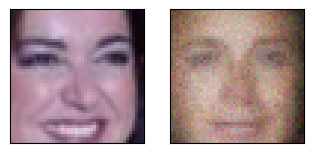

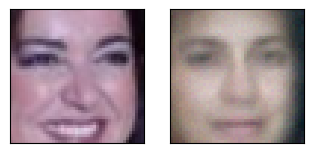

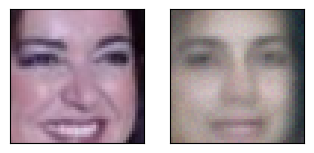

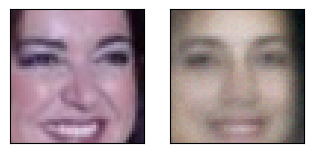

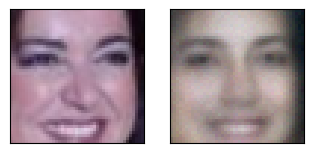

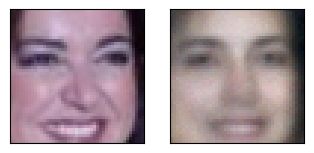

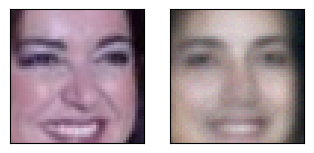

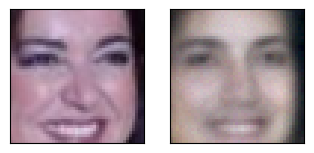

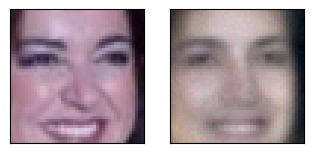

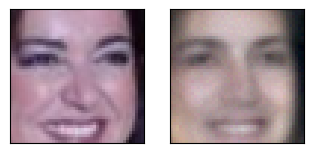

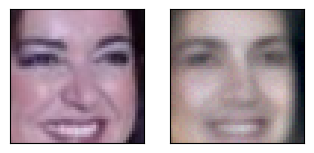

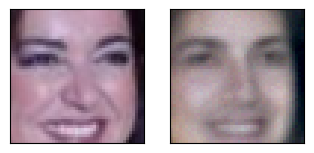

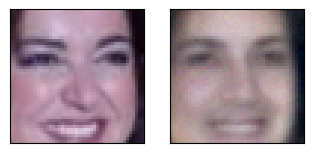

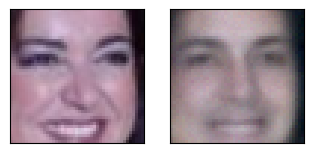

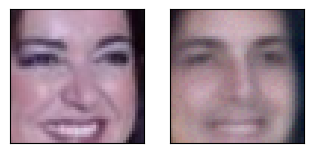

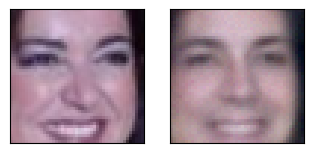

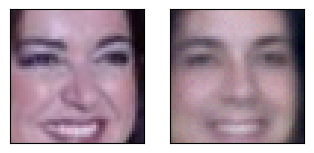

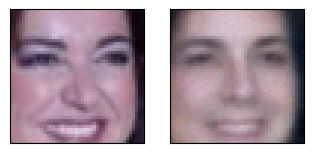

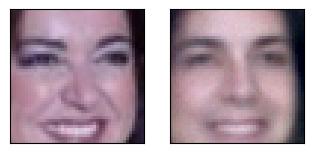

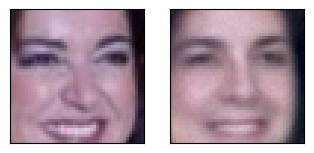

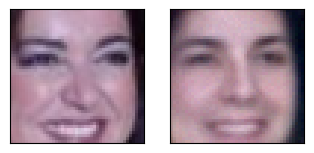

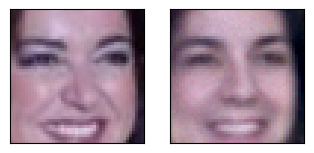

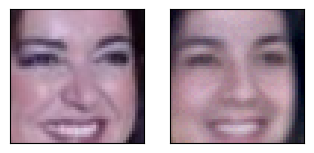

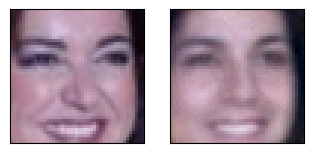

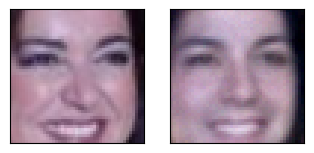

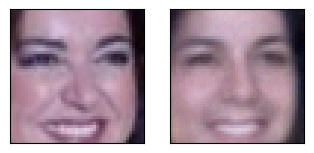

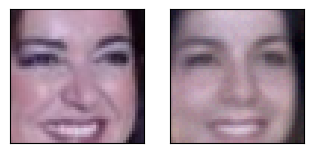

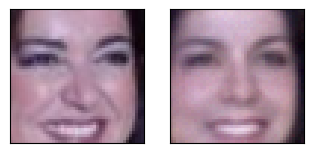

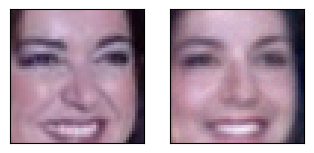

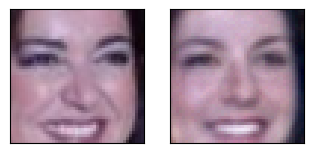

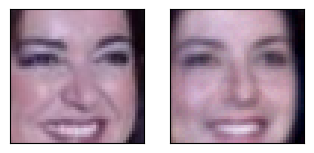

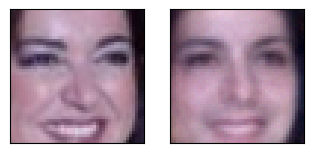

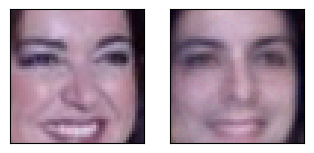

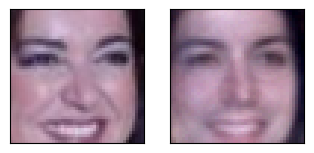

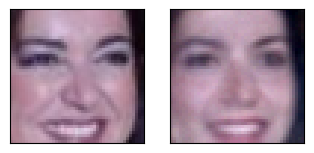

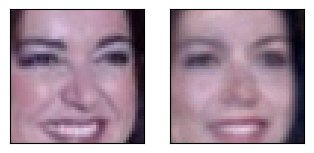

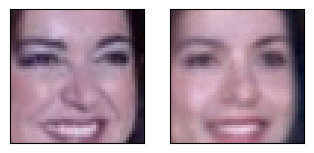

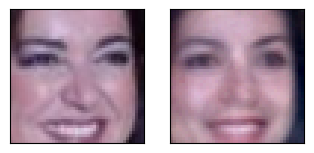

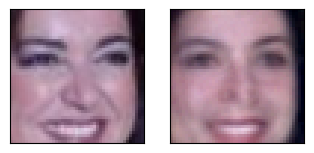

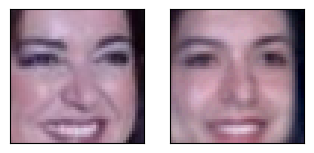

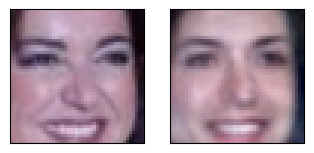

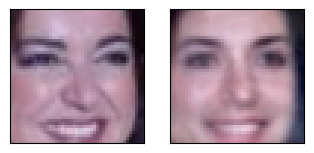

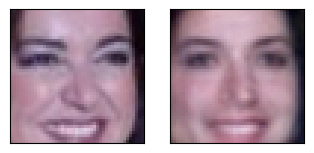

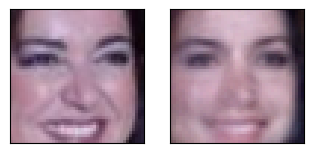

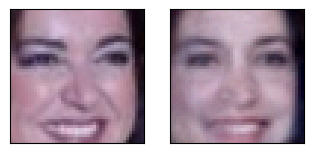

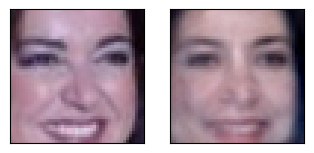

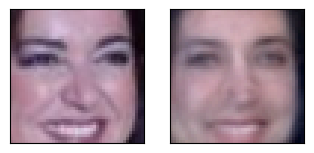

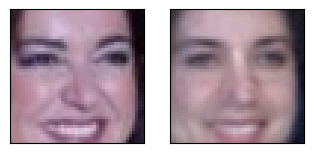

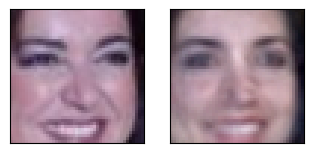

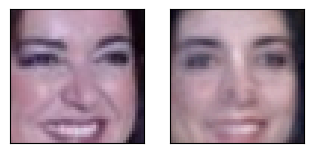

In [70]:
history = train(X_train, X_val, model_auto, epochs=50, batch_size=64)

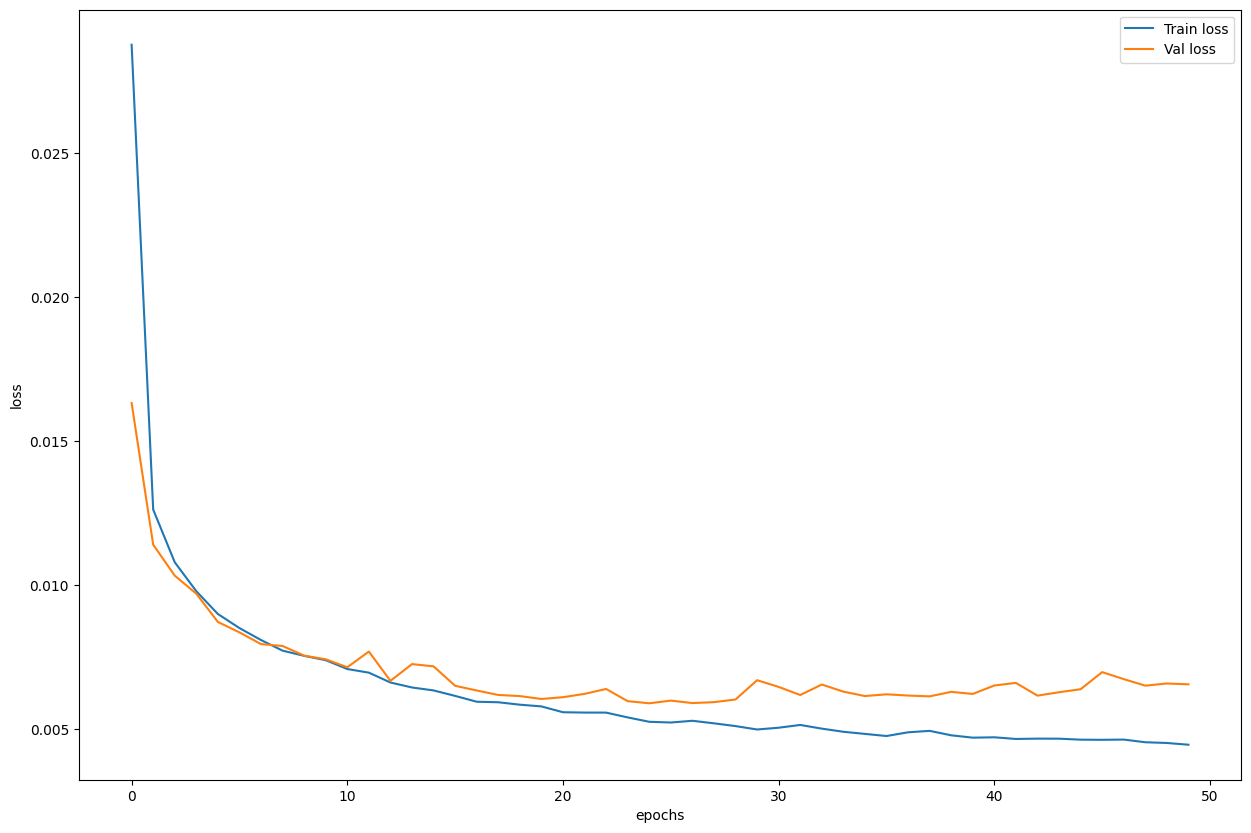

In [71]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## Sampling

Let's generate some samples from random vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

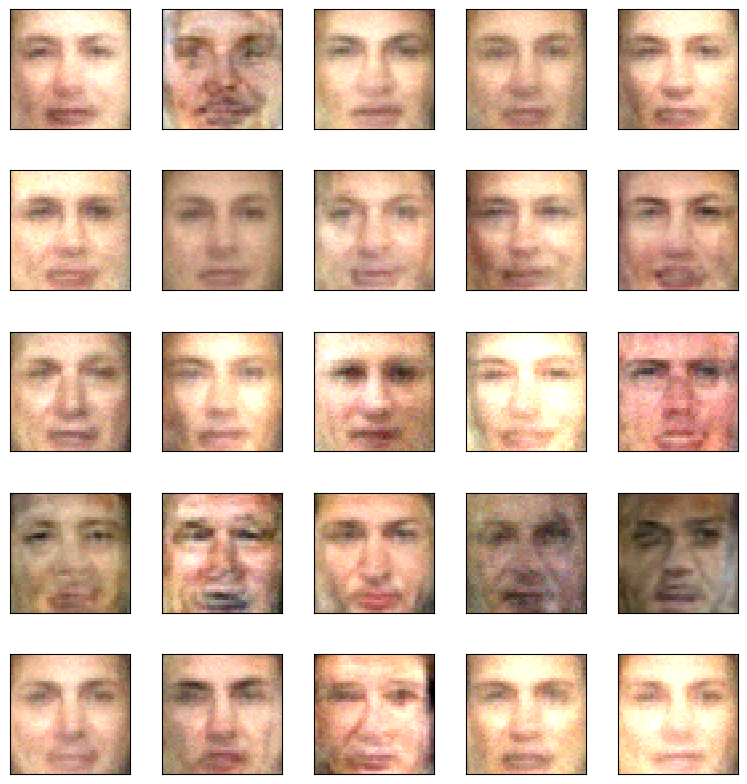

In [72]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_auto.eval()
    output = model_auto.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Adding smile and glasses

Let's find some attributes like smiles or glasses on the photo and try to add it to the photos which don't have it. We will use the second dataset for it. It contains a bunch of such attributes. 

In [73]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [74]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [75]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

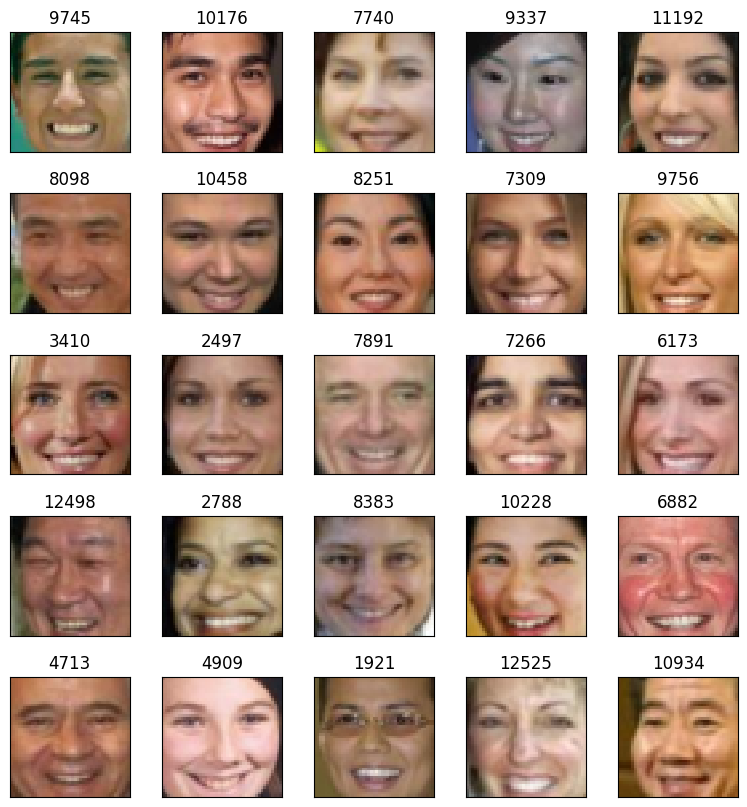

In [76]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

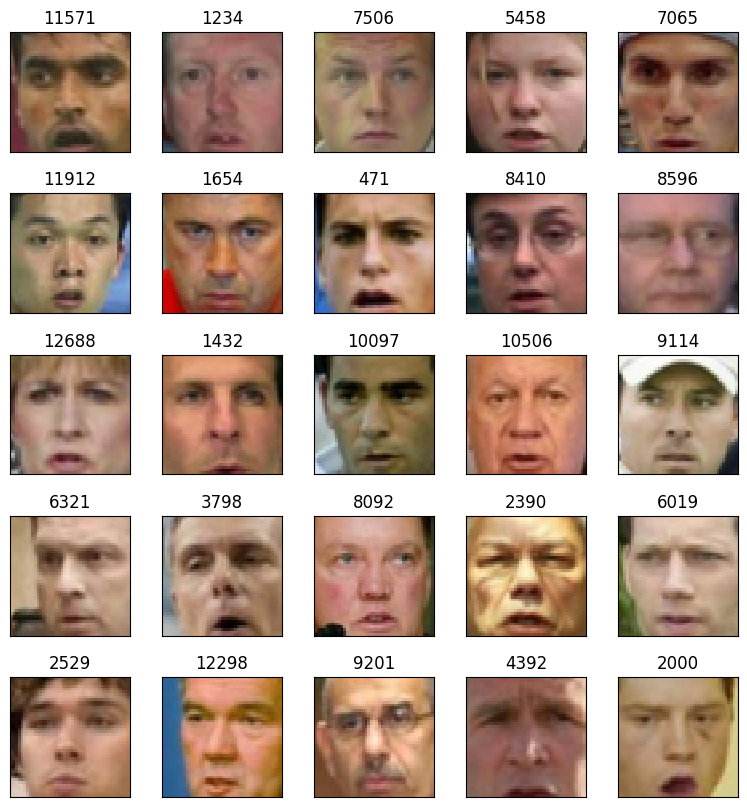

In [77]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

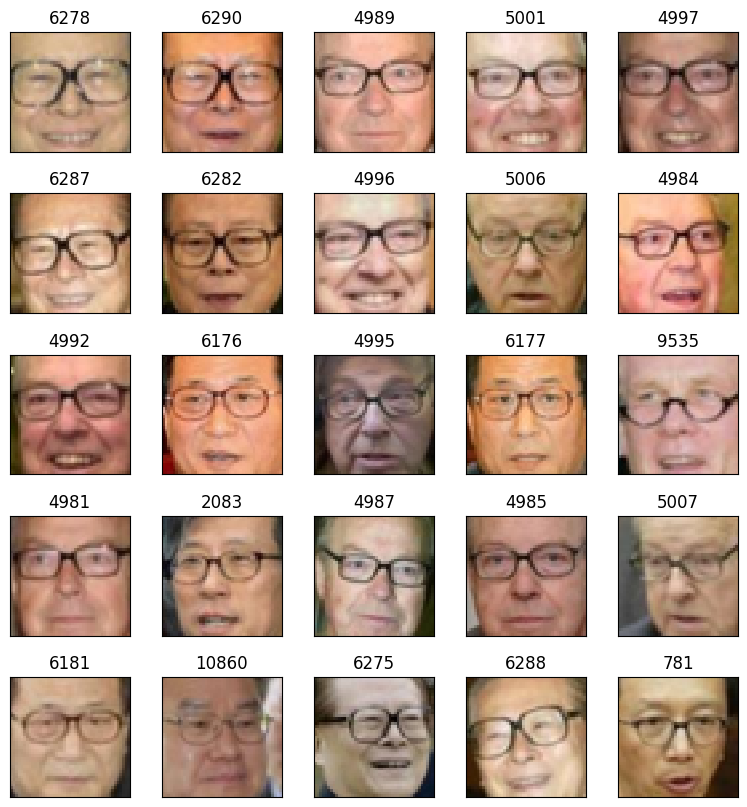

In [78]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

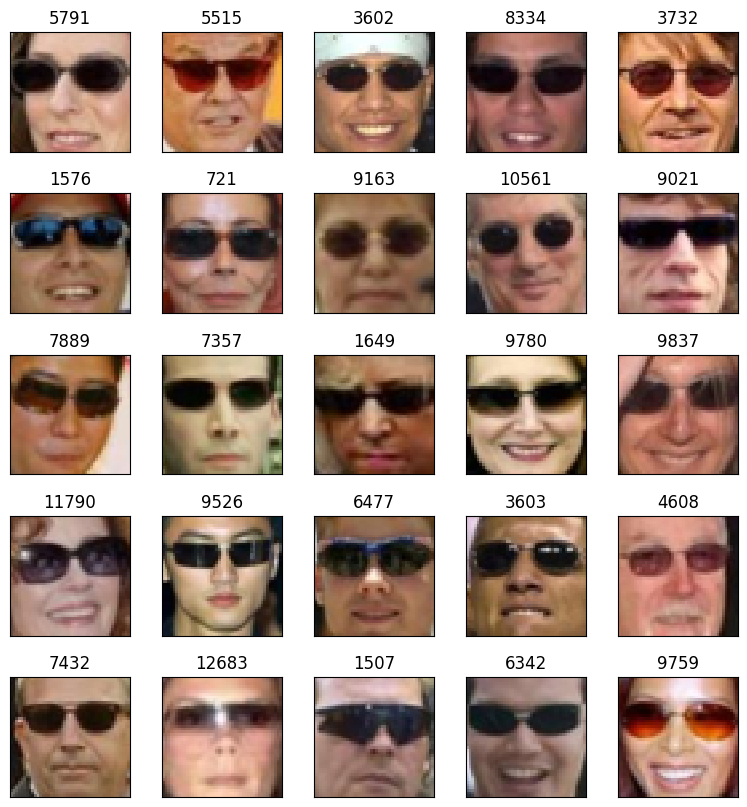

In [79]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

Calculating latent space vector for the selected images.

In [80]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_auto.eval()
        output = model_auto.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_auto.eval()
        output = model_auto.decode(inputs)        
        return output

In [81]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipyke

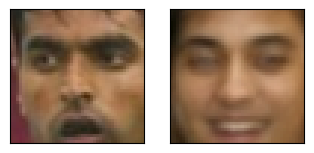

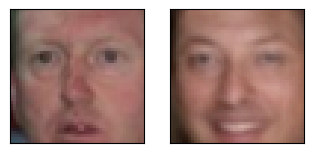

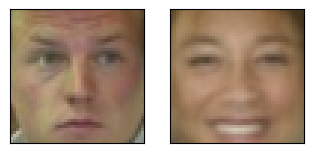

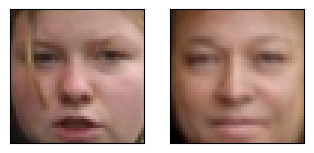

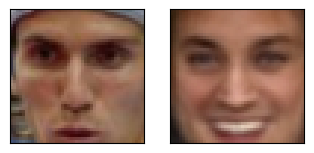

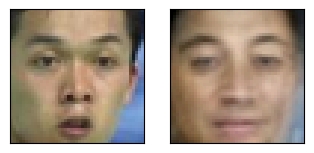

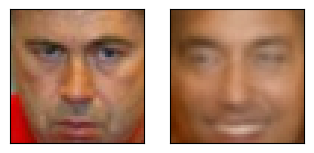

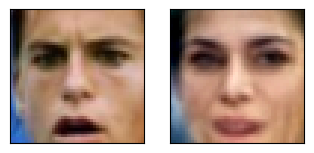

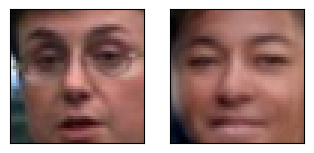

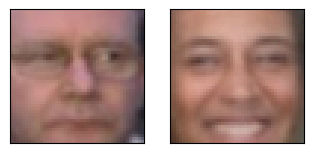

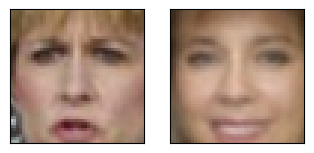

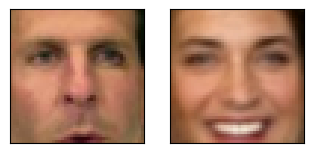

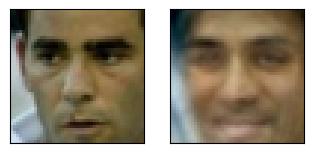

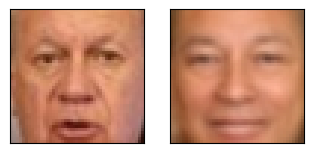

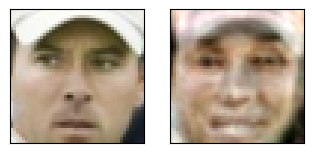

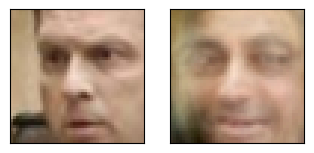

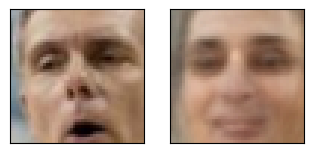

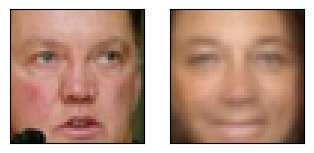

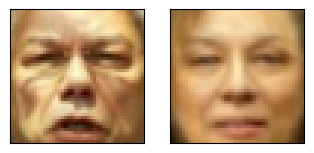

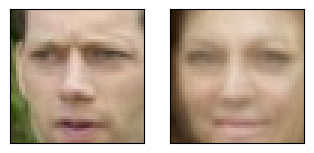

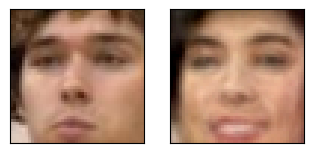

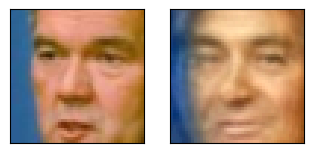

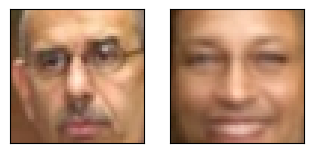

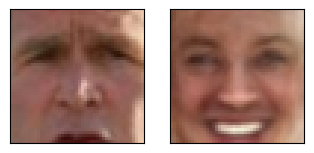

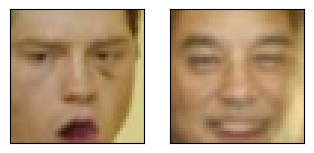

In [82]:
make_me_smile(no_smile_ids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

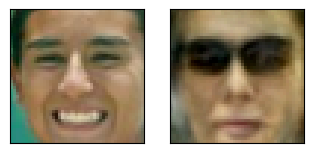

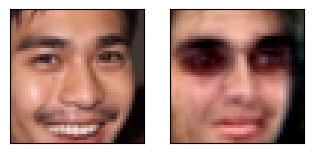

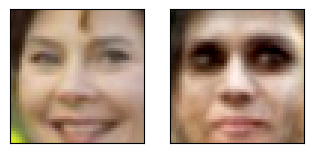

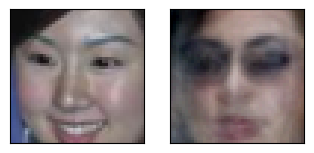

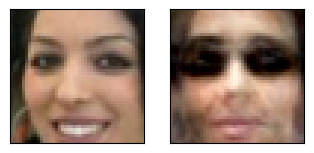

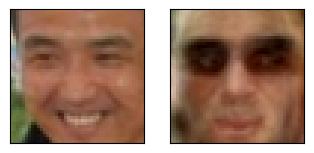

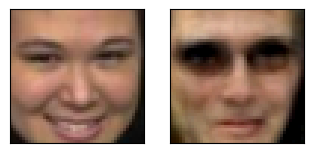

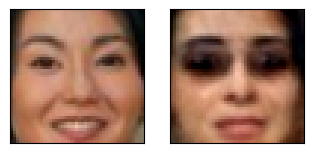

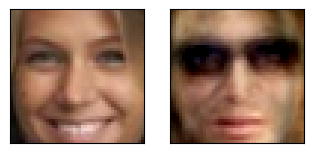

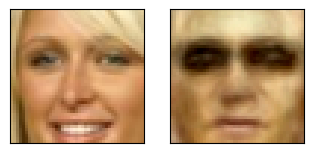

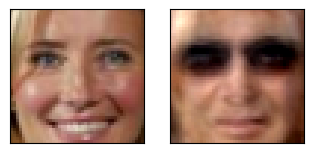

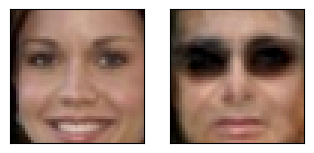

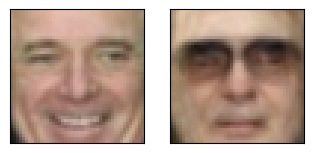

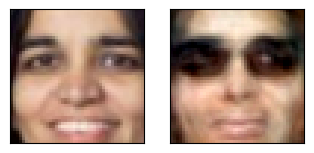

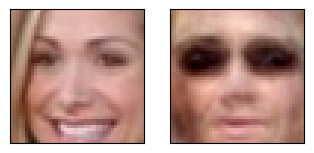

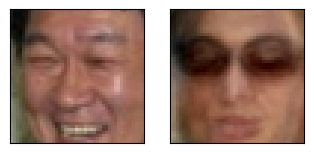

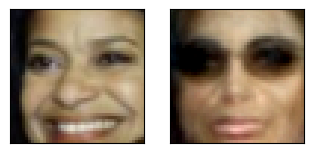

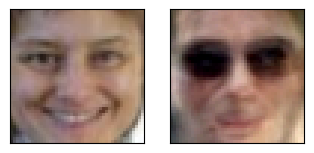

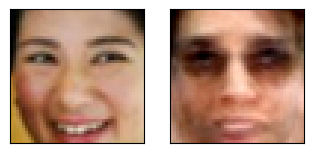

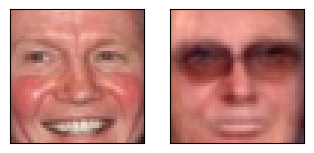

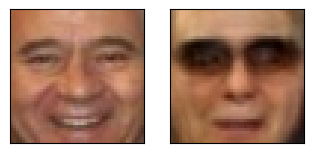

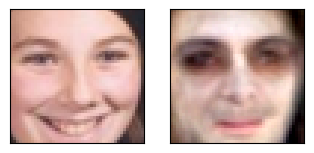

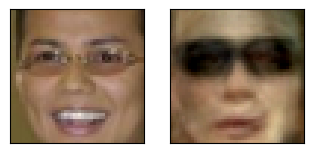

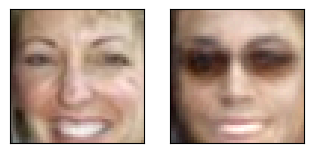

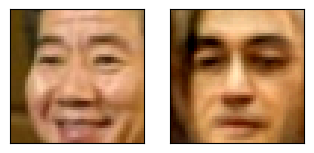

In [83]:
give_me_sunglasses(smile_ids)

While the concept is pretty straightforward the simple autoencoder have some disadvantages. Let's explore them and try to do better.

## Variational autoencoder

So far we have trained our encoder to reconstruct the very same image that we've transfered to latent space. That means that when we're trying to **generate** new image from the point decoder never met we're getting _the best image it can produce_, but the quelity is not good enough. 

> **In other words the encoded vectors may not be continuous in the latent space.**

In other hand Variational Autoencoders makes not only one encoded vector but **two**:
- vector of means, μ;
- vector of standard deviations, σ.

![https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png](https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png)

> picture from https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf



So we're going to try to use VAE to create better new data. The difference in thinking between VAE and AE is that VAE does not map images as "numerical codes", but as "distributions". 

It will be easier to understand with another simpler example, if we map the 'new moon' image to a normal distribution with µ=1, then it is equivalent to adding noise around 1, where not only does 1 represent the 'new moon', but the values around 1 also represent The "new moon" is not only represented by 1, but also by the values around 1, except that 1 is most like the "new moon". Mapping the "full moon" to a normal distribution with µ=10, all values around 10 also represent the "full moon". Then with code=5, it has the characteristics of both a 'new moon' and a 'full moon', so the probability of decoding is a 'half moon'. This is the idea behind VAE.

![](https://img2020.cnblogs.com/blog/2226924/202104/2226924-20210421184519712-1309789927.jpg)

The overall structure of VAE is similar to that of AE, except that the Encoder of AE outputs the code directly, whereas the Encoder of VAE outputs a number of normally distributed means (μ1, μ2...μn) and standard deviations (σ1,σ2...σn), and then from each normal distribution N(μ1,σ21),N(μ2,σ22)...N(μn,σ2n) Sampling gives the code (Z1,Z2...Zn) and the code is fed to the Decoder for decoding.

In [84]:
dim_z = 256

In [85]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [86]:
model_vae = VAE().to(DEVICE)

In [87]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:02<01:45,  2.15s/it]

loss:  508657.71098654176

Epoch 001 train_loss: 508657.7110 val_loss: 493431.4107


epoch:   4%|▍         | 2/50 [00:03<01:30,  1.89s/it]

loss:  495541.99730270356

Epoch 002 train_loss: 495541.9973 val_loss: 490015.8845


epoch:   6%|▌         | 3/50 [00:05<01:25,  1.83s/it]

loss:  493574.6668935467

Epoch 003 train_loss: 493574.6669 val_loss: 488346.2588


epoch:   8%|▊         | 4/50 [00:07<01:20,  1.76s/it]

loss:  491408.6048884226

Epoch 004 train_loss: 491408.6049 val_loss: 486798.2343


epoch:  10%|█         | 5/50 [00:09<01:21,  1.81s/it]

loss:  489733.99126610946

Epoch 005 train_loss: 489733.9913 val_loss: 486087.9271


epoch:  12%|█▏        | 6/50 [00:11<01:22,  1.87s/it]

loss:  488693.46990322426

Epoch 006 train_loss: 488693.4699 val_loss: 482493.5203


epoch:  14%|█▍        | 7/50 [00:13<01:22,  1.91s/it]

loss:  488101.6293721467

Epoch 007 train_loss: 488101.6294 val_loss: 483009.9353


epoch:  16%|█▌        | 8/50 [00:15<01:20,  1.91s/it]

loss:  486286.71476721513

Epoch 008 train_loss: 486286.7148 val_loss: 481850.7533


epoch:  18%|█▊        | 9/50 [00:17<01:19,  1.94s/it]

loss:  486719.39808380493

Epoch 009 train_loss: 486719.3981 val_loss: 480585.8628


epoch:  20%|██        | 10/50 [00:19<01:22,  2.07s/it]

loss:  485344.4043076493

Epoch 010 train_loss: 485344.4043 val_loss: 480447.5796


epoch:  22%|██▏       | 11/50 [00:21<01:14,  1.92s/it]

loss:  484211.5650947546

Epoch 011 train_loss: 484211.5651 val_loss: 479045.6584


epoch:  24%|██▍       | 12/50 [00:23<01:18,  2.06s/it]

loss:  483543.24818842736

Epoch 012 train_loss: 483543.2482 val_loss: 478698.8072


epoch:  26%|██▌       | 13/50 [00:25<01:12,  1.96s/it]

loss:  483215.03089927713

Epoch 013 train_loss: 483215.0309 val_loss: 478341.6397


epoch:  28%|██▊       | 14/50 [00:26<01:08,  1.91s/it]

loss:  482695.9558520187

Epoch 014 train_loss: 482695.9559 val_loss: 477707.5805


epoch:  30%|███       | 15/50 [00:29<01:10,  2.02s/it]

loss:  482482.66704958864

Epoch 015 train_loss: 482482.6670 val_loss: 477752.8918


epoch:  32%|███▏      | 16/50 [00:31<01:07,  1.98s/it]

loss:  482909.5868544322

Epoch 016 train_loss: 482909.5869 val_loss: 478845.3931


epoch:  34%|███▍      | 17/50 [00:32<01:04,  1.95s/it]

loss:  482827.0574917967

Epoch 017 train_loss: 482827.0575 val_loss: 479331.6558


epoch:  36%|███▌      | 18/50 [00:35<01:05,  2.05s/it]

loss:  481840.1082113729

Epoch 018 train_loss: 481840.1082 val_loss: 476642.3204


epoch:  38%|███▊      | 19/50 [00:37<01:07,  2.18s/it]

loss:  481442.20887031575

Epoch 019 train_loss: 481442.2089 val_loss: 476737.5928


epoch:  40%|████      | 20/50 [00:40<01:07,  2.25s/it]

loss:  481140.9085906292

Epoch 020 train_loss: 481140.9086 val_loss: 477380.5342


/tmp/ipykernel_10479/1482019581.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
epoch:  42%|████▏     | 21/50 [00:42<01:01,  2.14s/it]

loss:  482156.737562714

Epoch 021 train_loss: 482156.7376 val_loss: 476938.3438


epoch:  44%|████▍     | 22/50 [00:44<01:00,  2.17s/it]

loss:  481082.1184923079

Epoch 022 train_loss: 481082.1185 val_loss: 479106.7214


epoch:  46%|████▌     | 23/50 [00:46<00:55,  2.07s/it]

loss:  481038.4448785548

Epoch 023 train_loss: 481038.4449 val_loss: 477057.9591


epoch:  48%|████▊     | 24/50 [00:48<00:53,  2.07s/it]

loss:  480727.77718993725

Epoch 024 train_loss: 480727.7772 val_loss: 475491.5503


epoch:  50%|█████     | 25/50 [00:50<00:52,  2.10s/it]

loss:  480513.12769729644

Epoch 025 train_loss: 480513.1277 val_loss: 477416.9659


epoch:  52%|█████▏    | 26/50 [00:52<00:51,  2.16s/it]

loss:  480663.6968105027

Epoch 026 train_loss: 480663.6968 val_loss: 475506.4967


epoch:  54%|█████▍    | 27/50 [00:54<00:49,  2.14s/it]

loss:  480235.8155643666

Epoch 027 train_loss: 480235.8156 val_loss: 475964.0241


epoch:  56%|█████▌    | 28/50 [00:56<00:44,  2.01s/it]

loss:  480478.7889777915

Epoch 028 train_loss: 480478.7890 val_loss: 477700.5226


epoch:  58%|█████▊    | 29/50 [00:58<00:44,  2.10s/it]

loss:  480295.02498454443

Epoch 029 train_loss: 480295.0250 val_loss: 475276.5587


epoch:  60%|██████    | 30/50 [01:00<00:41,  2.07s/it]

loss:  480523.85506824235

Epoch 030 train_loss: 480523.8551 val_loss: 476004.7772


epoch:  62%|██████▏   | 31/50 [01:02<00:38,  2.00s/it]

loss:  480317.6594585196

Epoch 031 train_loss: 480317.6595 val_loss: 475363.6302


epoch:  64%|██████▍   | 32/50 [01:04<00:37,  2.07s/it]

loss:  480075.23278485826

Epoch 032 train_loss: 480075.2328 val_loss: 476504.1675


epoch:  66%|██████▌   | 33/50 [01:06<00:35,  2.07s/it]

loss:  480292.75028236164

Epoch 033 train_loss: 480292.7503 val_loss: 475730.8789


epoch:  68%|██████▊   | 34/50 [01:08<00:33,  2.07s/it]

loss:  479582.7784605645

Epoch 034 train_loss: 479582.7785 val_loss: 474907.4133


epoch:  70%|███████   | 35/50 [01:11<00:33,  2.22s/it]

loss:  479747.2219406862

Epoch 035 train_loss: 479747.2219 val_loss: 475332.5991


epoch:  72%|███████▏  | 36/50 [01:13<00:32,  2.29s/it]

loss:  479375.4078267667

Epoch 036 train_loss: 479375.4078 val_loss: 477383.4012


epoch:  74%|███████▍  | 37/50 [01:16<00:29,  2.28s/it]

loss:  479519.2142530198

Epoch 037 train_loss: 479519.2143 val_loss: 475363.7850


epoch:  76%|███████▌  | 38/50 [01:18<00:27,  2.26s/it]

loss:  479151.16348737397

Epoch 038 train_loss: 479151.1635 val_loss: 475121.0109


epoch:  78%|███████▊  | 39/50 [01:20<00:24,  2.24s/it]

loss:  479094.9625633084

Epoch 039 train_loss: 479094.9626 val_loss: 474881.7926


epoch:  80%|████████  | 40/50 [01:22<00:22,  2.26s/it]

loss:  478941.11118657264

Epoch 040 train_loss: 478941.1112 val_loss: 476244.1585


epoch:  82%|████████▏ | 41/50 [01:24<00:19,  2.16s/it]

loss:  479532.0437987445

Epoch 041 train_loss: 479532.0438 val_loss: 476590.5041


epoch:  84%|████████▍ | 42/50 [01:26<00:16,  2.10s/it]

loss:  479037.93313825614

Epoch 042 train_loss: 479037.9331 val_loss: 474421.7136


epoch:  86%|████████▌ | 43/50 [01:28<00:14,  2.07s/it]

loss:  478615.0451912331

Epoch 043 train_loss: 478615.0452 val_loss: 474090.9504


epoch:  88%|████████▊ | 44/50 [01:31<00:12,  2.13s/it]

loss:  478636.30473802786

Epoch 044 train_loss: 478636.3047 val_loss: 474010.0040


epoch:  90%|█████████ | 45/50 [01:32<00:10,  2.03s/it]

loss:  478775.3400926741

Epoch 045 train_loss: 478775.3401 val_loss: 474375.9609


epoch:  92%|█████████▏| 46/50 [01:35<00:08,  2.10s/it]

loss:  478890.9837196238

Epoch 046 train_loss: 478890.9837 val_loss: 474595.2439


epoch:  94%|█████████▍| 47/50 [01:36<00:05,  1.95s/it]

loss:  478756.36561221944

Epoch 047 train_loss: 478756.3656 val_loss: 475434.4776


epoch:  96%|█████████▌| 48/50 [01:38<00:03,  1.90s/it]

loss:  478538.29214915825

Epoch 048 train_loss: 478538.2921 val_loss: 475150.4523


epoch:  98%|█████████▊| 49/50 [01:40<00:01,  1.91s/it]

loss:  478394.2034935562

Epoch 049 train_loss: 478394.2035 val_loss: 473939.3880


epoch: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]

loss:  478262.5461765265

Epoch 050 train_loss: 478262.5462 val_loss: 474652.3492


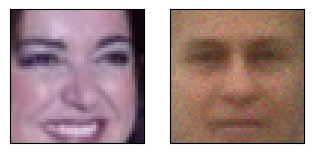

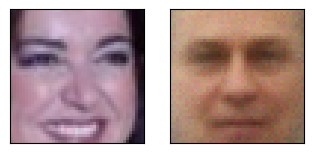

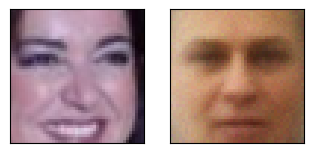

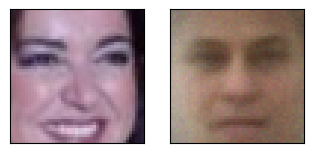

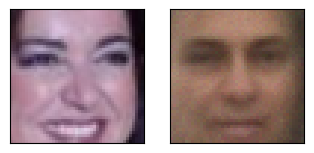

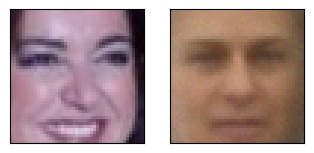

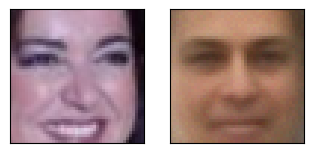

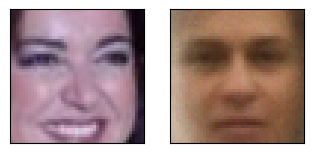

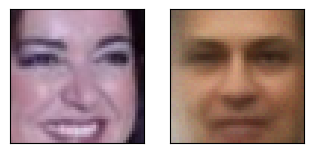

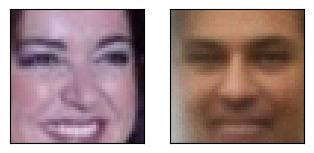

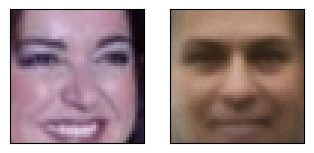

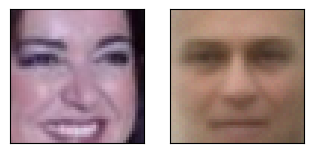

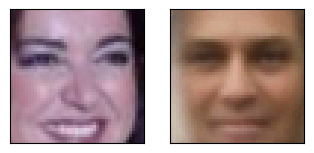

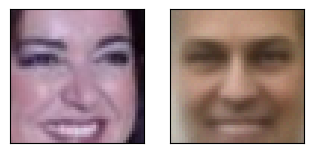

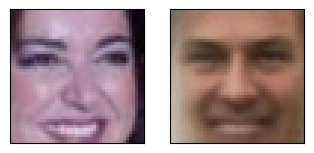

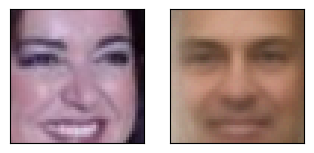

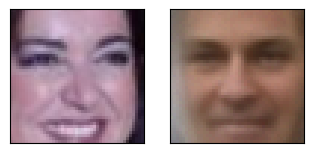

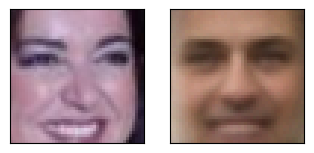

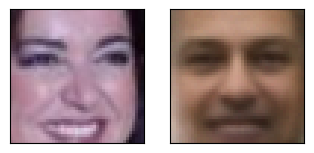

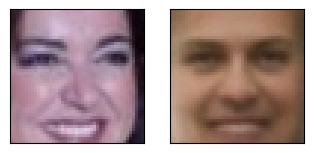

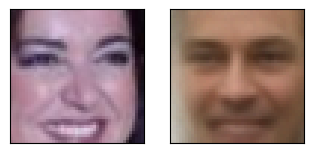

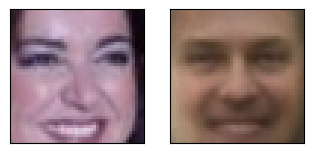

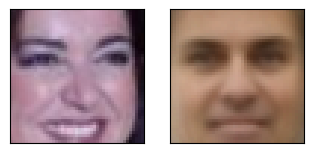

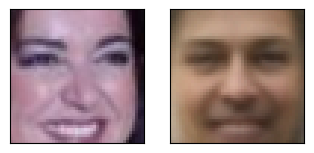

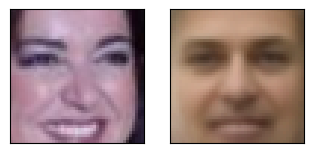

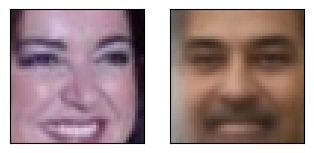

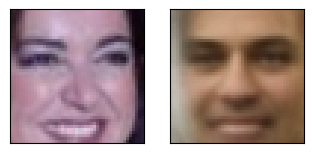

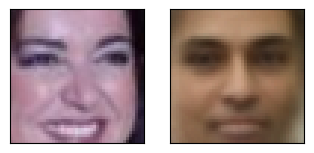

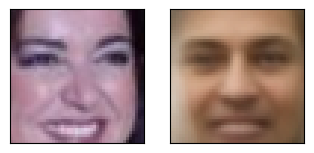

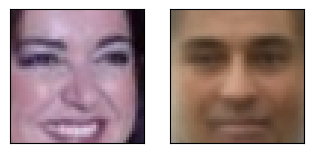

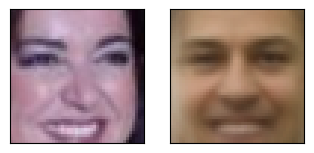

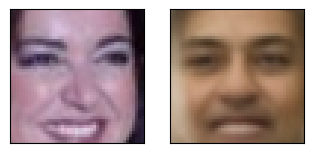

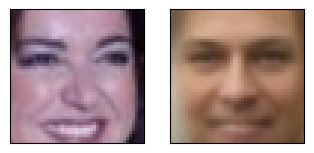

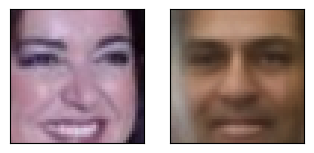

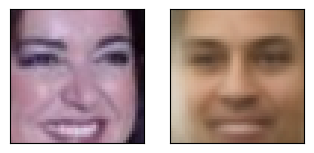

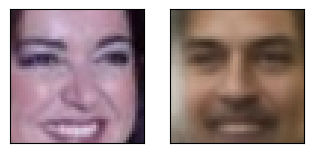

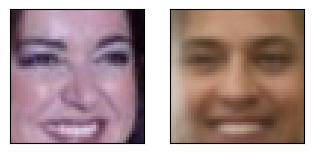

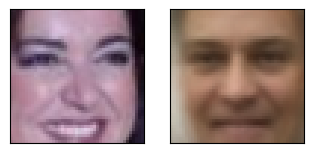

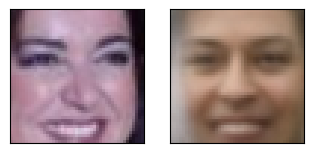

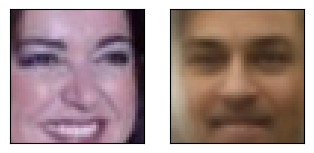

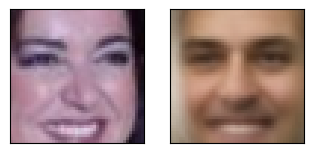

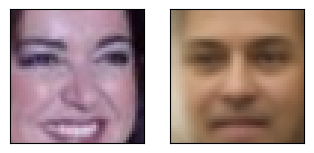

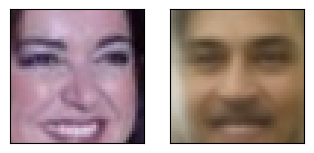

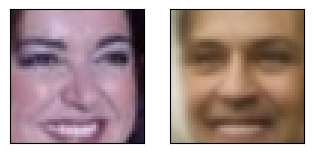

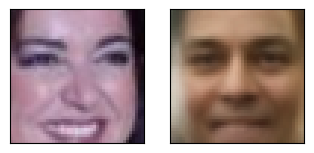

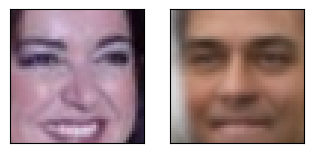

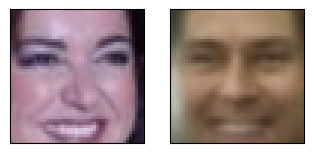

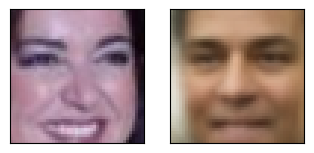

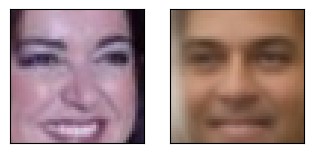

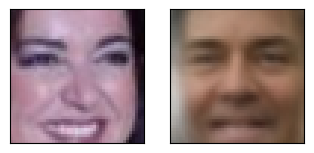

In [88]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

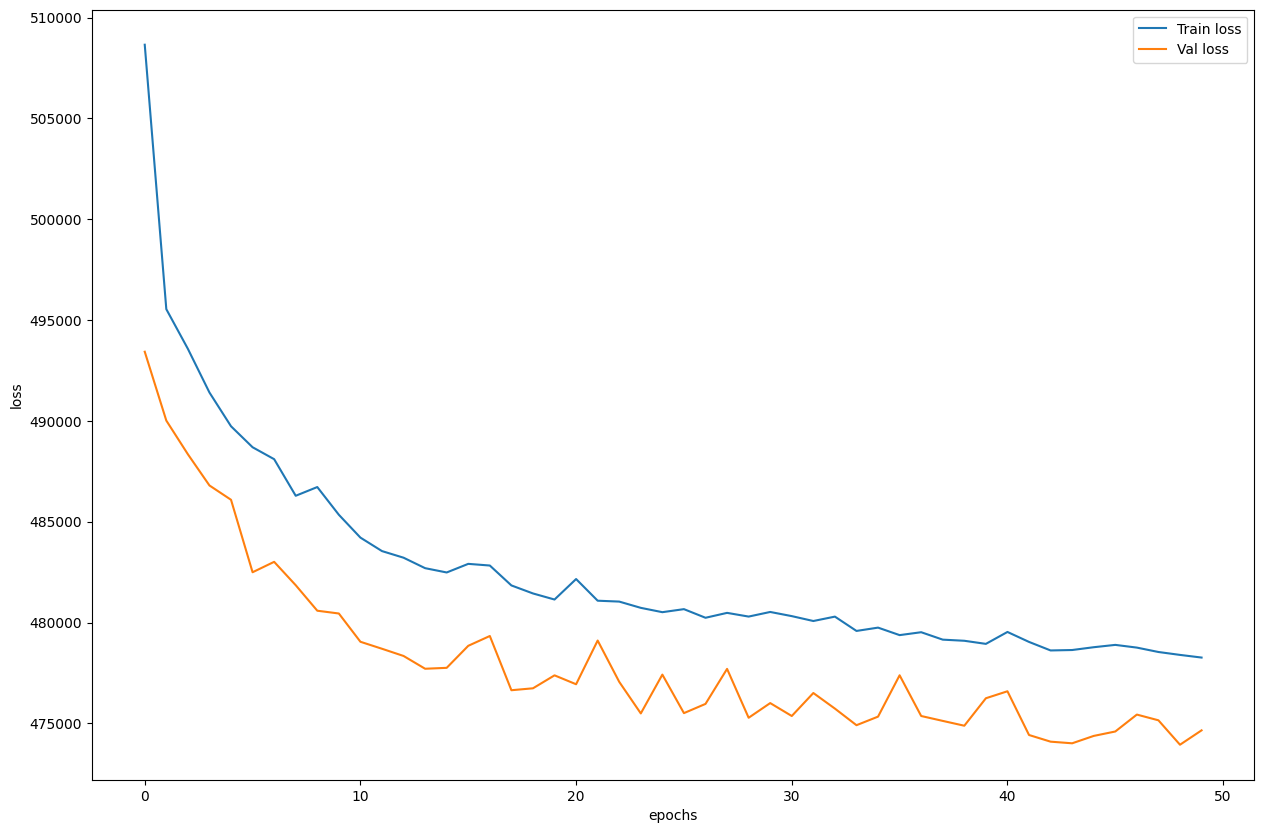

In [89]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## Conclusion

Variational autoencoders are cool. Although models in this particular notebook are simple they let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces and high-resolution digital artwork.
These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma et al. and Rezende et al.

## Acknowledgments

Thanks to SERGEI AVERKIEV for creating the Kaggle open-source project [Variational Autoencoder and Faces Generation](https://www.kaggle.com/code/averkij/variational-autoencoder-and-faces-generation). It inspires the majority of the content in this chapter.